In [1]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')

In [2]:
tf.__version__

'2.0.0-rc1'

In [3]:
dataset_name = 'mnist'

In [4]:
import tensorflow_datasets as tfds

info = tfds.builder(dataset_name).info

print(info)

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    urls=['https://storage.googleapis.com/cvdf-datasets/mnist/'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [5]:
intermediate_dim = 20
input_shape=(28, 28, 1) # image shape
batch_size = 100
latent_dim = 50

In [6]:
TRAIN_BUF = 600
TEST_BUF = 100


In [7]:
import tensorflow_datasets as tfds
# Construct a tf.data.Dataset
train_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TRAIN_BUF).batch(batch_size)
try:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TEST).shuffle(TEST_BUF).batch(batch_size)
except:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TEST_BUF).batch(batch_size)


In [8]:
_instance_scale=1.0
for data in train_ds:
    _instance_scale = float(data['image'][0].numpy().max())
    break

In [9]:
_instance_scale

255.0

In [10]:
enc_lays2 = [
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(latent_dim)
]

dec_lays2 = [
    tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    
    # No activation
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME")
]

In [11]:
enc_mean_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

enc_var_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

dec_lays = [tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu')]

## First Time

In [12]:
#from utils.data_and_files.file_utils import make_random_string
#from time import gmtime, strftime

#model_name = 'AE_' + make_random_string(5) + strftime("%a_%d_%b_%Y_%H_%M", gmtime())
#print(model_name)

In [13]:
model_name = dataset_name+'VAE'

In [14]:
recoding_dir='.\\recoding\\'+model_name

In [15]:
import os

In [16]:
os.path.join(recoding_dir, model_name)

'.\\recoding\\mnistVAE\\mnistVAE'

In [17]:
from training.autoencoders.VAE import VAE

Using TensorFlow backend.
DEBUG:matplotlib:$HOME=C:\Users\Khalid
DEBUG:matplotlib:CONFIGDIR=C:\Users\Khalid\.matplotlib
DEBUG:matplotlib:matplotlib data path: C:\ProgramData\Anaconda3\envs\tf02\lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:loaded rc file C:\ProgramData\Anaconda3\envs\tf02\lib\site-packages\matplotlib\mpl-data\matplotlibrc
DEBUG:matplotlib:matplotlib version 3.1.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'nt', 'winreg', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'encodings.cp1252', 'site', 'os', 'stat', '_stat', 'ntpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'types', 'importlib', 'importlib._bootstrap', 'impo

DEBUG:matplotlib:CACHEDIR=C:\Users\Khalid\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\Khalid\.matplotlib\fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [18]:
variables_params = \
[
    {
        'name': 'encoder_mean', 
        'input_shape':input_shape,
        'output_shape':latent_dim,
        'layers': enc_mean_lays
    }
    ,
    
     {
        'name': 'encoder_logvar', 
        'input_shape':input_shape,
        'output_shape':latent_dim,
        'layers':enc_var_lays
    }
    ,
    
        {
        'name': 'decoder', 
        'input_shape':latent_dim,
        'output_shape':input_shape,
        'layers':dec_lays
    }
]

In [19]:
_restore = os.path.join(recoding_dir, 'var_save_dir')

In [20]:
_restore

'.\\recoding\\mnistVAE\\var_save_dir'

In [21]:
vae = VAE( 
    model_name=model_name, 
    input_shape=input_shape, 
    latent_dim=latent_dim, 
    variables_params=variables_params, 
    restore=None
    )

INFO:tensorflow:Single-worker CollectiveAllReduceStrategy with local_devices = ('/device:GPU:0',), communication = CollectiveCommunication.NCCL


INFO:tensorflow:Single-worker CollectiveAllReduceStrategy with local_devices = ('/device:GPU:0',), communication = CollectiveCommunication.NCCL


  DEBUG    | MultiWorker Mirrored Strategy ... 
DEBUG:pythonConfig:MultiWorker Mirrored Strategy ... 


Model: "encoder_mean"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 28, 28, 20)        40        
_________________________________________________________________
dense_3 (Dense)              (None, 28, 28, 20)        420       
_________________________________________________________________
dense_4 (Dense)              (None, 28, 28, 20)        420       
_________________________________________________________________
flatten_1 (Flatten)          (None, 15680)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                784050    
Total params: 784,930
Trainable params: 784,930
Non-trainable params: 0
_________________________________________________________________



  WARNING  | None


Model: "encoder_logvar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 28, 28, 20)        40        
_________________________________________________________________
dense_6 (Dense)              (None, 28, 28, 20)        420       
_________________________________________________________________
dense_7 (Dense)              (None, 28, 28, 20)        420       
_________________________________________________________________
flatten_2 (Flatten)          (None, 15680)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                784050    
Total params: 784,930
Trainable params: 784,930
Non-trainable params: 0
_________________________________________________________________



  WARNING  | None


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_9 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_10 (Dense)             (None, 40)                1640      
_________________________________________________________________
flatten_3 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 784)               32144     
Total params: 37,464
Trainable params: 37,464
Non-trainable params: 0
_________________________________________________________________



  WARNING  | None


In [22]:
import numpy as np
n_generated = 36
#random_latent = np.random.normal(size=[n_generated, latent_dim])
#np.save(file='random_latent.npy', arr=random_latent)
random_latent = tf.constant(np.load(file='random_latent.npy'))

  INFO     | ==================================================================
INFO:pythonConfig:==================================================================


  DEBUG    | TRAIN
    Epoch: 9
    logpx_z: -35416.87109375
    logpz: -42634.05078125
    logqz_x: 31290.357421875
    Total: -79.17732238769531
    Elapsed: 39.031877
DEBUG:pythonConfig:TRAIN
    Epoch: 9
    logpx_z: -35416.87109375
    logpz: -42634.05078125
    logqz_x: 31290.357421875
    Total: -79.17732238769531
    Elapsed: 39.031877


  INFO     | ==================================================================
INFO:pythonConfig:==================================================================


  INFO     | ==================================================================
INFO:pythonConfig:==================================================================


  DEBUG    | TEST
    Epoch: 9
    logpx_z: -5787.59228515625
    logpz: -7092.333984375
    logqz_x: 5188.50830078125
    Total: -74.878662109375
    Elapsed: 1.941088
DEBUG:pythonConfig:TEST
    Epoch: 9
    logpx_z: -5787.59228515625
    logpz: -7092.333984375
    logqz_x: 5188.50830078125
    Total: -74.878662109375
    Elapsed: 1.941088


  INFO     | ==================================================================
INFO:pythonConfig:==================================================================


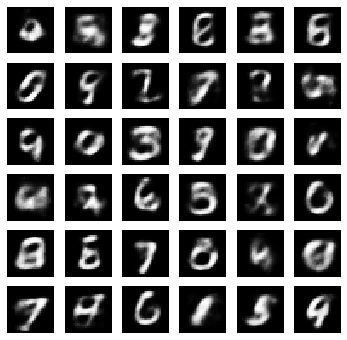

Epochs Progress, Training Iterations 599: 100%|████████████████████████████████████████| 10/10 [07:04<00:00, 42.47s/it]
Testing ...: 4950it [00:02, 1945.37it/s]


In [23]:
vae.fit(
    train_dataset=train_ds, 
    test_dataset=test_ds,
    instance_name='image',
    instance_scale=_instance_scale,
    epochs=10,
    learning_rate=1e-3,
    random_latent=random_latent,
    latent_dim=latent_dim ,
    recoding_dir=recoding_dir,
    gray_plot=True,
    generate_epoch=5,
    save_epoch=5
)

In [ ]:
#from ground_truth_datasets.datasets import load